In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import DateOffset
from pandas.plotting import lag_plot, autocorrelation_plot
import numpy as np
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt
from sklearn.metrics import mean_absolute_error
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Defaults for plotting
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()

# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))
sns.mpl.rc('xtick', labelsize=13)    # fontsize x tick labels
sns.mpl.rc('ytick', labelsize=13)    # fontsize y tick labels
sns.mpl.rc('legend', fontsize=14)    # fontsize legend

## Load data

In [2]:
# Define paths
snp_data_path = '../data/snp_prices_daily_Jan_2019_May_2020.csv'
btc_data_path = '../data/bitcoin_may_2016_april_2020.csv'
snp_trends_data_path = '../data/snp_trends.csv'
btc_trends_data_path = '../data/bitcoin_trends.csv'
snp_sentim_data_path = '../data/fin_sentim.csv'
btc_sentim_data_path = '../data/bitcoin_sentim.csv'

# Keep only the 'Data' and 'Close' (closing pirce) columns for both dataset
snp = pd.read_csv(snp_data_path, usecols=['Date','Close']).rename(columns={'Close': 'Price'}).set_index('Date')
snp_trends_data = pd.read_csv(snp_trends_data_path, sep='\t').rename(columns={'date': 'Date', 's&p 500': 'Trends'}).set_index('Date')
snp_sent_data = pd.read_csv(snp_sentim_data_path).set_index('Date')
snp.index = pd.to_datetime(snp.index)


btc = pd.read_csv(btc_data_path, usecols=['Date','Close']).rename(columns={'Close': 'Price'}).set_index('Date')
btc_trends_data = pd.read_csv(btc_trends_data_path, sep='\t').rename(columns={'date': 'Date', 'bitcoin': 'Trends'}).set_index('Date')
btc_sent_data = pd.read_csv(btc_sentim_data_path, sep='\t').set_index('Date')
btc.index = pd.to_datetime(btc.index)


# S&P 500
<hr>

## Data cleaning

We found out tha some days are not present in the data we dowloaded (13 days). Also, the weekends are not present because weekends are not trading days.
We first added all the missing days, then droped the weekends and replaced the values of remaining `Nan` weekdays with the price of the previus day.


In [196]:
# First add all the days missing
snp = snp.asfreq(DateOffset(days=1))

# Then find the weekends
weekend_mask = snp.index.weekday >= 5
nan_idx = np.where(snp.Price.isnull())[0]

# Drop weekends from snp dataframe
snp = snp.drop(snp[weekend_mask].index)

# Replace all no weekdays with the price of the previus day (only 13)
for i in range(len(snp)):
    if snp.iloc[i].isnull().any():
        snp.iloc[i] = snp.iloc[i-1]


# Count missing weekdays
print(f'The missing values:   {len(nan_idx)}')
print(f'The missing weekends: {weekend_mask.sum()}')
print(f'The missing weekdays: {len(nan_idx) - weekend_mask.sum()}')
print(f'Nan remaining: {snp.isna().sum()[0]}')

The missing values:   146
The missing weekends: 146
The missing weekdays: 0
Nan remaining: 0


In [4]:
# Merge trends with snp prices
snp_trends = pd.merge(pd.merge(snp, snp_trends_data, left_index=True, right_index=True, how='left'), snp_sent_data, left_index=True, right_index=True, how='left')

# Add a polarity 1 or -1 to influence the trends when predicting given the mean sentiment of the news in this day
snp_trends['Sent_polarity'] = snp_trends['Sent_mean'].apply(lambda sent: 1 if sent > 0 else -1)

snp_trends.head()

,Price,Trends,Sent_mean,Sent_count,Sent_polarity
Date,,,,,
2019-01-02,2510.030029,1764,0.032447,525,1
2019-01-03,2447.889893,2100,0.034056,474,1
2019-01-04,2531.939941,1764,0.087821,351,1
2019-01-07,2549.689941,1239,0.064426,543,1
2019-01-08,2574.409912,1575,0.076823,568,1


In [197]:
print(f'Nan existing: {snp_trends.isna().sum()[0]}')

Nan existing: 0


### Plots

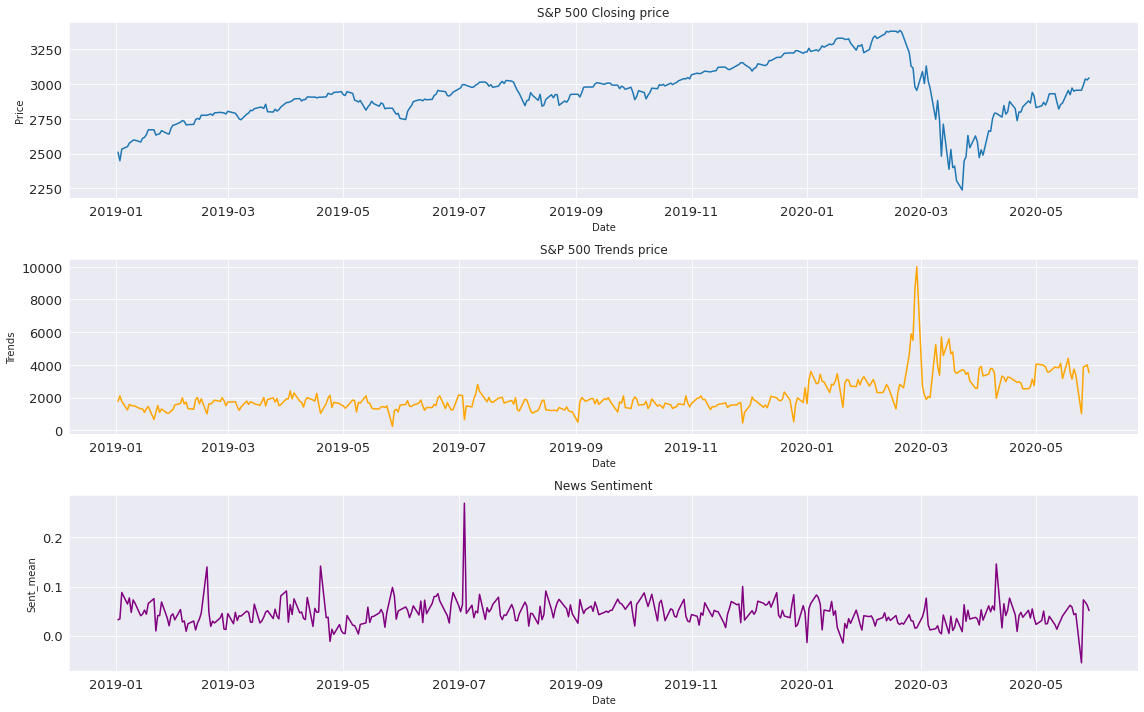

In [227]:
f, ax = plt.subplots(3, 1, figsize=(16,10))
sns.lineplot(data=snp_trends, x=snp_trends.index, y=snp_trends.Price, ax=ax[0]).set_title('S&P 500 Closing price')
sns.lineplot(data=snp_trends, x=snp_trends.index, y=snp_trends.Trends, color='orange', ax=ax[1]).set_title('S&P 500 Trends price')
sns.lineplot(data=snp_trends, x=snp_trends.index, y=snp_trends.Sent_mean, color='purple', ax=ax[2]).set_title('News Sentiment')
f.tight_layout()

In [145]:
fig = make_subplots(rows=2, cols=1, subplot_titles=("S&P 500 Price", "S&P 500 Trends"))
fig.append_trace(go.Scatter(x=snp_trends.index,y=snp_trends.Price, name='S&P 500 Price'), row=1, col=1)
fig.append_trace(go.Scatter(x=snp_trends.index,y=snp_trends.Trends/100, name='S&P 500 Trends'), row=2, col=1)
# fig.append_trace(go.Scatter(x=snp_trends.index,y=snp_trends.Sent_mean, name='News Sentiment'), row=3, col=1)

fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Trends", row=2, col=1)

fig.update_layout(height=600, width=1000, showlegend=False)
fig.show()
pio.write_html(fig, file='../figs/lines_snp_pts.html', auto_open=True)

### Lag plots

We can see that for some plots the data gather around a diagonal line.
We can say that there is some form of correlation between our series and the lagged ones.

This holds especially for `lag(-1)`, `lag(-5)`.  `lag(-10)` and `Lag(-14)` seems to be the less correlated compared to previus ones.

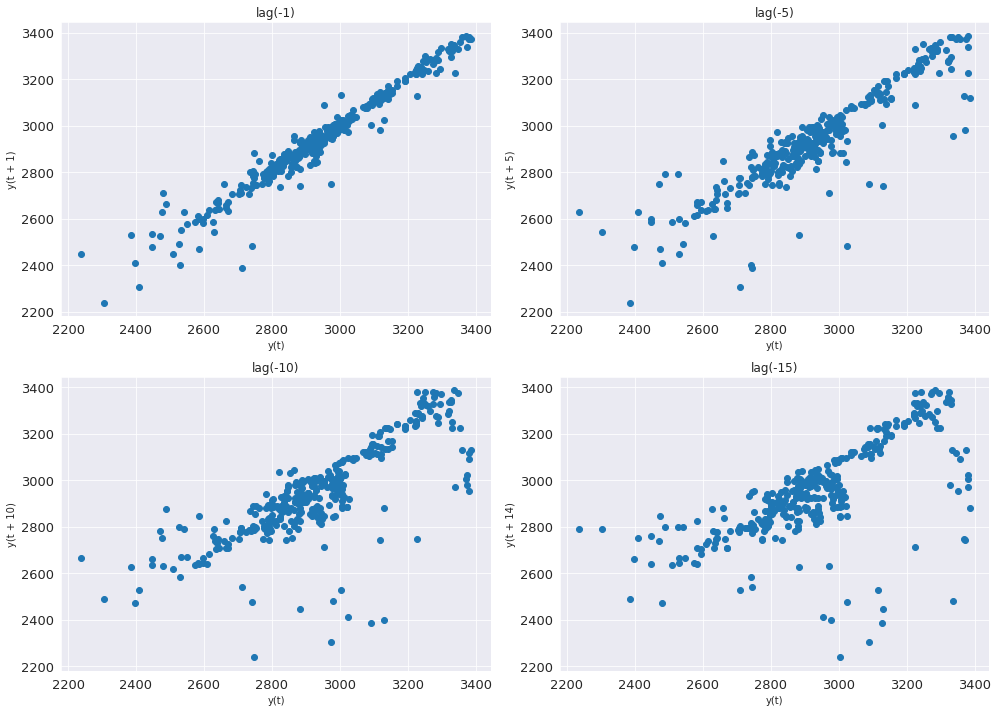

In [198]:
# Create the figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

# Create all the lag plots: -1. -2, -10, -14
lag_plot(snp_trends[['Price']], 1,  ax=ax[0][0])
ax[0][0].set_title('lag(-1)')

lag_plot(snp_trends[['Price']], 5,  ax=ax[0][1])
ax[0][1].set_title('lag(-5)')

lag_plot(snp_trends[['Price']], 10,  ax=ax[1][0])
ax[1][0].set_title('lag(-10)')

lag_plot(snp_trends[['Price']], 14, ax=ax[1][1])
ax[1][1].set_title('lag(-15)')

fig.tight_layout()
plt.show()

In [89]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("Lag -1", "Lag -5", "Lag -10", "Lag -14"))
df1 = pd.concat([snp_trends[['Price']], snp_trends[['Price']].rename(columns={'Price':'Lag-1'}).shift(1)], axis=1).dropna()
df5 = pd.concat([snp_trends[['Price']], snp_trends[['Price']].rename(columns={'Price':'Lag-5'}).shift(5)], axis=1).dropna()
df10 = pd.concat([snp_trends[['Price']], snp_trends[['Price']].rename(columns={'Price':'Lag-10'}).shift(10)], axis=1).dropna()
df14 = pd.concat([snp_trends[['Price']], snp_trends[['Price']].rename(columns={'Price':'Lag-14'}).shift(14)], axis=1).dropna()

# Add traces
fig.add_trace(
    go.Scatter(x=df1['Price'], y=df1['Lag-1'], mode='markers', name='lag-1'),
    row=1, col=1)
fig.add_trace(
    go.Scatter(x=df5['Price'], y=df5['Lag-5'], mode='markers', name='lag-5'),
    row=1, col=2)
fig.add_trace(
    go.Scatter(x=df10['Price'], y=df10['Lag-10'], mode='markers', name='lag-10'),
    row=2, col=1)
fig.add_trace(
    go.Scatter(x=df14['Price'], y=df14['Lag-14'], mode='markers', name='lag-14'),
    row=2, col=2)

# Update xaxis properties
fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)
fig.update_xaxes(title_text="Price", row=2, col=1)
fig.update_xaxes(title_text="Price", row=2, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Lag -1 Price ", row=1, col=1)
fig.update_yaxes(title_text="Lag -5 Price ", row=1, col=2)
fig.update_yaxes(title_text="Lag -10 Price ", row=2, col=1)
fig.update_yaxes(title_text="Lag -14 Price ", row=2, col=2)


fig.update_layout(height=700, width=1000)
fig.show()
pio.write_html(fig, file='../figs/scatter_snp.html', auto_open=True)

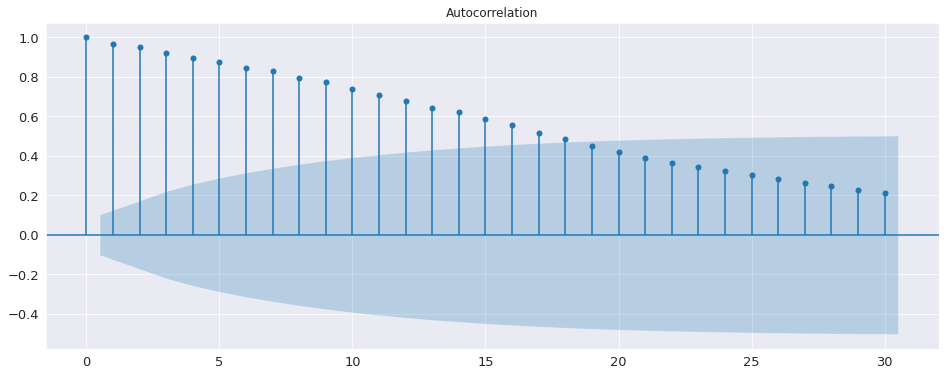

In [7]:
# plot the autocorrelation for 30 days
plot_acf(snp, lags=30)
plt.show()

## Build models

Use the `AutoReg` model from `statsmodels` to build and fit auto regression models to our data
<hr>

## In-sample models
Predict data that are already seen. Feed the whole data to the models and predict the whole time series

### Base in-sample model

In [8]:
# Define lags for the models:
model_lags = [1, 2, 3, 4, 5]

base_snp = AutoReg(snp_trends.Price.values, lags=model_lags).fit()
print(base_snp.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  368
Model:                     AutoReg(5)   Log Likelihood               -1884.652
Method:               Conditional MLE   S.D. of innovations             43.508
Date:                Fri, 18 Dec 2020   AIC                              7.584
Time:                        17:56:55   BIC                              7.660
Sample:                             5   HQIC                             7.614
                                  368                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     79.0954     33.266      2.378      0.017      13.894     144.296
y.L1           0.7009      0.052     13.398      0.000       0.598       0.803
y.L2           0.4876      0.063      7.740      0.0

In [9]:
trends_snp = AutoReg(snp_trends.Price.values, lags=model_lags, exog=snp_trends.Trends.values).fit()
print(trends_snp.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  368
Model:                   AutoReg-X(5)   Log Likelihood               -1876.904
Method:               Conditional MLE   S.D. of innovations             42.589
Date:                Fri, 18 Dec 2020   AIC                              7.547
Time:                        17:56:55   BIC                              7.633
Sample:                             5   HQIC                             7.581
                                  368                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     89.7623     32.674      2.747      0.006      25.722     153.802
y.L1           0.6664      0.052     12.833      0.000       0.565       0.768
y.L2           0.4760      0.062      7.711      0.0

In [10]:
trends_news_snp = AutoReg(snp_trends.Price.values, lags=model_lags, exog=(snp_trends.Trends * snp_trends.Sent_polarity).values).fit()
print(trends_news_snp.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  368
Model:                   AutoReg-X(5)   Log Likelihood               -1877.656
Method:               Conditional MLE   S.D. of innovations             42.677
Date:                Fri, 18 Dec 2020   AIC                              7.551
Time:                        17:56:55   BIC                              7.637
Sample:                             5   HQIC                             7.586
                                  368                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     91.4586     32.795      2.789      0.005      27.181     155.736
y.L1           0.6679      0.052     12.832      0.000       0.566       0.770
y.L2           0.4784      0.062      7.736      0.0

Base. in sample MAE: 11.432
Trends, in sample MAE: 13.530
Trends with news, in sample MAE: 13.352


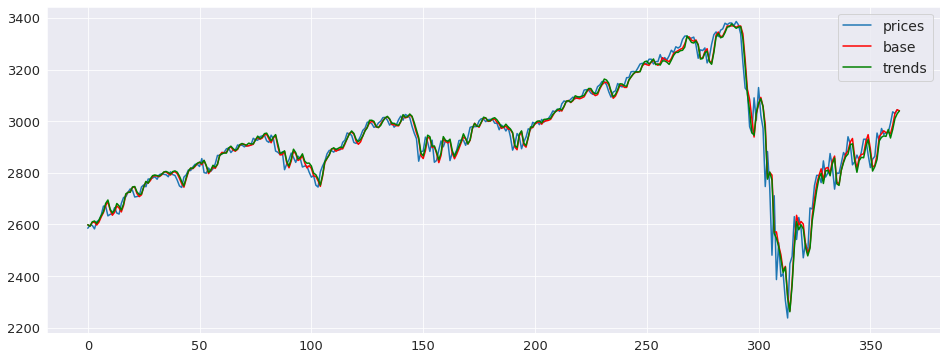

In [200]:
# In sample prediction for both models
pred_base = base_snp.predict(start=len(model_lags), end=len(snp_trends.Price.values))
pred_trends = trends_snp.predict(start=len(model_lags), end=len(snp_trends.Price.values), exog_oos=snp_trends.Trends.values)
pred_trends_news = trends_news_snp.predict(start=len(model_lags), end=len(snp_trends.Price.values), exog_oos=(snp_trends.Trends * snp_trends.Sent_polarity).values)


# Compute MAE
mae_base = mean_absolute_error(snp_trends.iloc[len(model_lags)-1:,0], pred_base)
mae_trends = mean_absolute_error(snp_trends.iloc[len(model_lags)-1:,0], pred_trends)
mae_trends_news = mean_absolute_error(snp_trends.iloc[len(model_lags)-1:,0], pred_trends_news)
print('Base. in sample MAE: %.3f' % mae_base)
print('Trends, in sample MAE: %.3f' % mae_trends)
print('Trends with news, in sample MAE: %.3f' % mae_trends_news)

# Plor in sample predictions (this is not the figure to reproduce!)
plt.plot(snp_trends.iloc[5:, 0].values )
plt.plot(pred_base, 'red')
plt.plot(pred_trends, 'green')
plt.legend(['prices', 'base', 'trends'])

## Out of sample models



In [212]:
# Define model lags
model_lags = [1, 2, 3, 4, 5]

# Store the predictions
y_base = []
y_trends = [] 
y_trends_news = [] 
dates_pred = []

# Skip the first 12 obs 
window_size = 12
for last_window_idx in range(snp_trends.shape[0] - window_size):  # Leaves out the last idx that we dont want eitherway
    roll = last_window_idx + window_size

    # Slice the original data to the training window
    price_window = snp_trends[:roll]['Price']

    # Slice the trends to the training window
    trends_window = snp_trends[:roll]['Trends']

    # Slice the sentiment to the training window        
    polarized_trends = trends_window * snp_trends[:roll]['Sent_polarity']

    # Train 2 modesl on the window
    base_model = AutoReg(price_window.values, lags= model_lags).fit()
    trends_model = AutoReg(price_window.values, lags= model_lags, exog=trends_window.values).fit(use_t=True)
    trends_news_model = AutoReg(price_window.values, lags= model_lags, exog=polarized_trends.values).fit(use_t=True)
    
    # Predict using the params of the model (manually)
    y_base.append( 
        np.sum([price_window.iloc[-1 * lag] * base_model.params[idx+1] for idx, lag in enumerate(model_lags)]) + base_model.params[0])

    y_trends.append(
        np.sum([price_window.iloc[-1 * lag] * trends_model.params[idx+1] for idx, lag in enumerate(model_lags)])
             + trends_model.params[0]
             + snp_trends.iloc[roll]['Trends'] * trends_model.params[len(model_lags)+1]) # idx of exog is sizeof(lags) + 1

    y_trends_news.append(
        np.sum([price_window.iloc[-1 * lag] * trends_news_model.params[idx+1] for idx, lag in enumerate(model_lags)])
             + trends_news_model.params[0]
             + snp_trends.iloc[roll]['Trends'] * trends_news_model.params[len(model_lags)+1]) # idx of exog is sizeof(lags) + 1        
    
    # Keep the predicted days also
    dates_pred.append(snp_trends.index[roll])

# Create a dataframe or the preictions
base_preds = pd.DataFrame({'Price_base': y_base}, index=dates_pred)
trends_preds = pd.DataFrame({'Price_trends': y_trends}, index=dates_pred)
trends_news_preds = pd.DataFrame({'Price_trends_news': y_trends_news}, index=dates_pred)

# Also concat the predictions with the main df (for printing reasons mainly)
prices_with_preds = pd.concat([snp_trends.iloc[window_size:][['Price']], base_preds, trends_preds, trends_news_preds], axis=1)

### Find the Overall MAE improvement and the MAE during turning points

In [214]:
from IPython.display import HTML

# Define turning points
turning_points = {'All time: 2020-02-15 - 2020-04-15': ('2020-02-15', '2020-04-15'),
                  'Focus on decrease: 2020-02-15 - 2020-03-03': ('2020-02-15', '2020-03-03'),
                  'Focus on increase: 2020-03-23 - 2020-04-15': ('2020-03-23', '2020-04-15')}

# For each turning point find the baseline mae & trends mae
rows_of_table = list()
for period in turning_points.values():
    prices = snp_trends[period[0]:period[1]]['Price']
    base_prices = base_preds[period[0]:period[1]]['Price_base']
    trends_prices = trends_preds[period[0]:period[1]]['Price_trends']
    trends_news_prices = trends_news_preds[period[0]:period[1]]['Price_trends_news']

    mae_base = mean_absolute_error(prices, base_prices)    
    mae_trends = mean_absolute_error(prices, trends_prices)
    mae_trends_news = mean_absolute_error(prices, trends_news_prices)

    rows_of_table.append([f'{period[0]}', f'{period[1]}', f'{mae_base:.5f}', f'{mae_trends:.5f}', f'{mae_trends_news:.5f}'])

# Add the overall mae also
prices = snp_trends[window_size:]['Price']
base_prices = base_preds['Price_base']
trends_prices = trends_preds['Price_trends']
trends_news_prices = trends_news_preds['Price_trends_news']
mae_base = mean_absolute_error(prices, base_prices)    
mae_trends = mean_absolute_error(prices, trends_prices)
mae_trends_news = mean_absolute_error(prices, trends_news_prices)
rows_of_table.insert(0, [f'Overall', '-', f'{mae_base:.5f}', f'{mae_trends:.5f}', f'{mae_trends_news:.5f}'])


table_df = pd.DataFrame(rows_of_table, columns=['Start', 'End', 'MAE base', 'MAE trends', 'MAE Trends news'])
HTML(table_df.to_html(index=False))  

Start,End,MAE base,MAE trends,MAE Trends news
Overall,-,28.01270,28.68178,28.52315
2020-02-15,2020-04-15,91.11102,92.18070,91.68320
2020-02-15,2020-03-03,57.05539,59.83447,58.57295
2020-03-23,2020-04-15,72.11216,83.59803,81.49704


We can see that overall the base model fits our data best, becuase trends can be missleading.


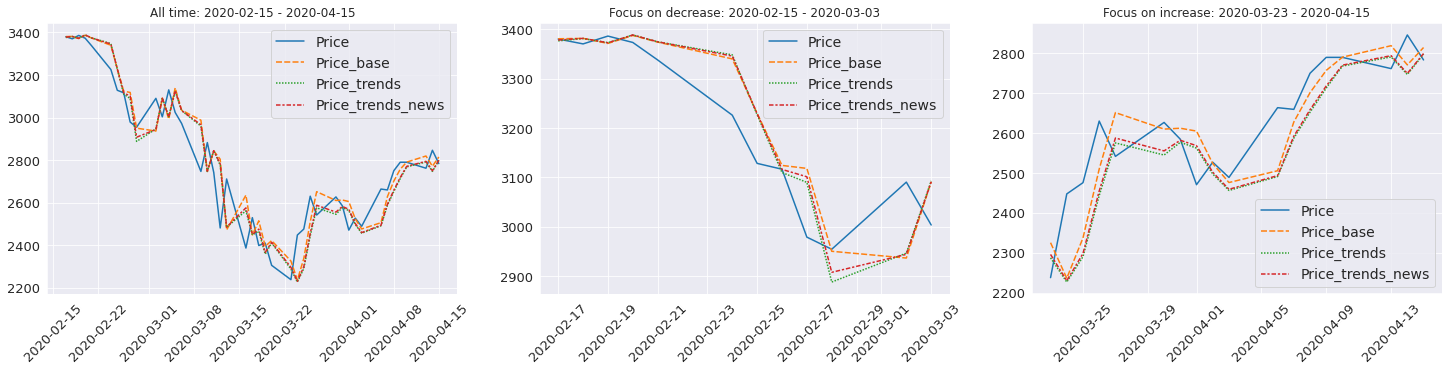

In [186]:
f,ax = plt.subplots(1,len(turning_points), figsize=(25,5))
for idx, period_with_names in enumerate(turning_points.items()):
    period = period_with_names[1]
    title = period_with_names[0]
    g = sns.lineplot(data=prices_with_preds[period[0]:period[1]], ax=ax[idx])
    g.set_title(title)
    for item in g.get_xticklabels():
        item.set_rotation(45)

f.savefig("../figs/snp_focus.pdf", bbox_inches='tight')

In [191]:
# Create figure
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=list(prices_with_preds['2020-02-15':'2020-04-15'].index), y=list(prices_with_preds['2020-02-15':'2020-04-15'].Price), name="S&P 500 Prices"))
fig.add_trace(
    go.Scatter(x=list(prices_with_preds['2020-02-15':'2020-04-15'].index), y=list(prices_with_preds['2020-02-15':'2020-04-15'].Price_base), name="Baseline", line=dict(dash='dash')))
fig.add_trace(
    go.Scatter(x=list(prices_with_preds['2020-02-15':'2020-04-15'].index), y=list(prices_with_preds['2020-02-15':'2020-04-15'].Price_trends), name="Trends", line=dict(dash='dash')))
fig.add_trace(
    go.Scatter(x=list(prices_with_preds['2020-02-15':'2020-04-15'].index), y=list(prices_with_preds['2020-02-15':'2020-04-15'].Price_trends_news), name="Trends & News", line=dict(dash='dash', color='orange')))


fig.update_layout(title="S&P 500 Predictions during covid", height=500, width=800)
fig.show()
pio.write_html(fig, file='../figs/lines_snp_covid.html', auto_open=True)

In [166]:
# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(prices_with_preds.index), y=list(prices_with_preds.Price), name="S&P 500 Prices"))
fig.add_trace(
    go.Scatter(x=list(prices_with_preds.index), y=list(prices_with_preds.Price_base), name="Baseline", line=dict(dash='dash')))
fig.add_trace(
    go.Scatter(x=list(prices_with_preds.index), y=list(prices_with_preds.Price_trends), name="Trends", line=dict(dash='dash')))
fig.add_trace(
    go.Scatter(x=list(prices_with_preds.index), y=list(prices_with_preds.Price_trends), name="Trends & News", line=dict(dash='dash', color='orange')))

# Set title
fig.update_layout(
    title_text="S&P Price predictions"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=1,label="1m",step="month",stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year",stepmode="todate"),
                dict(count=1,label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.update_layout(height=500, width=800)
fig.show()
pio.write_html(fig, file='../figs/snp_preds.html', auto_open=True)

# Bitcoin


In [15]:
# Merge trends with snp and sentiment analysis data
btc_trends = pd.merge(pd.merge(btc, btc_trends_data, left_index=True, right_index=True, how='left'), btc_sent_data, left_index=True, right_index=True, how='left')

# Some news_sentiments are Nan so will fill them with 1 in order not to affect the polarity
# and the trends influence on the predictions latter on
btc_trends.fillna(0.1, inplace=True)

# Add a polarity 1 or -1 to influence the trends when predicting given the mean sentiment of the news in this day
btc_trends['Sent_polarity'] = btc_trends['Sent_mean'].apply(lambda sent: 1 if sent > 0 else -1)

btc_trends.head()

,Price,Trends,Sent_mean,Sent_count,Sent_polarity
Date,,,,,
2016-12-01,756.773987,232,0.007973,7.0,1
2016-12-02,777.943970,224,0.087197,6.0,1
2016-12-03,771.155029,140,0.047273,5.0,1
2016-12-04,773.872009,180,0.106250,4.0,1
2016-12-05,758.700012,228,0.057626,8.0,1


Text(0.5, 1.0, 'News Sentiment')

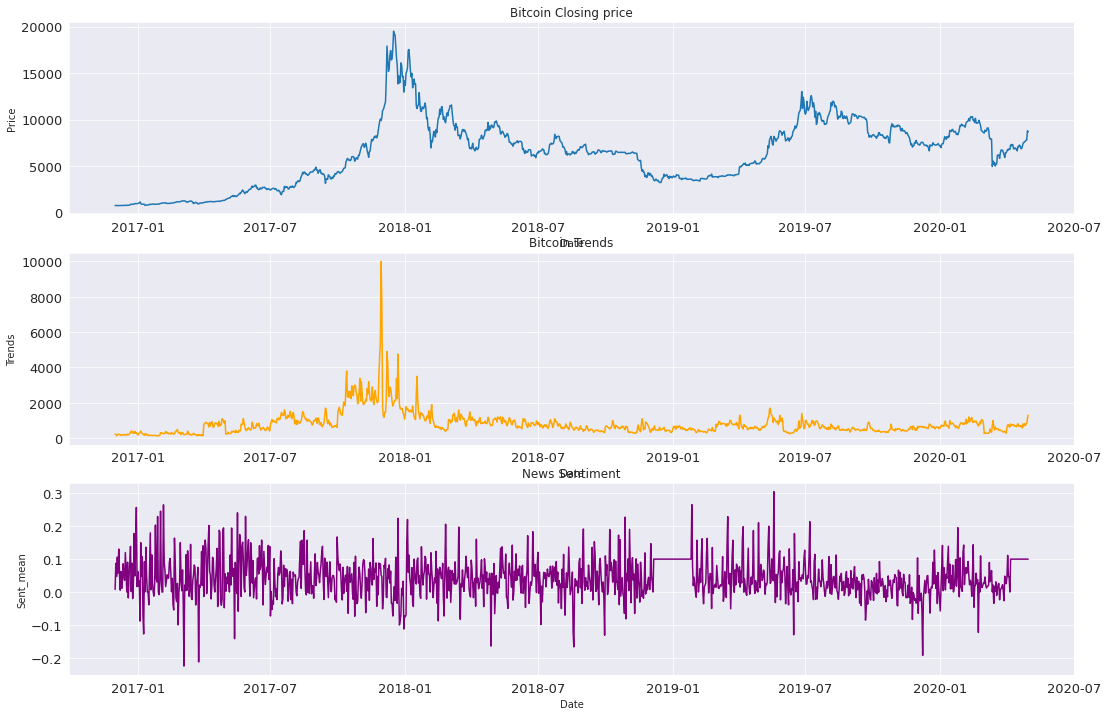

In [16]:
f, ax = plt.subplots(3, 1, figsize=(18,12))
sns.lineplot(data=btc_trends, x=btc_trends.index, y=btc_trends.Price, ax=ax[0]).set_title('Bitcoin Closing price')
sns.lineplot(data=btc_trends, x=btc_trends.index, y=btc_trends.Trends, color='orange', ax=ax[1]).set_title('Bitcoin Trends')
sns.lineplot(data=btc_trends, x=btc_trends.index, y=btc_trends.Sent_mean, color='purple', ax=ax[2]).set_title('News Sentiment')

In [146]:
fig = make_subplots(rows=2, cols=1, subplot_titles=("Bitcoin Price","Bitcoin Trends"))

fig.append_trace(go.Scatter(x=btc_trends.index,y=btc_trends.Price, name='Bitcoin Price'), row=1, col=1)
fig.append_trace(go.Scatter(x=btc_trends.index,y=btc_trends.Trends/100, name='Bitcoin Trends'), row=2, col=1)
# fig.append_trace(go.Scatter(x=btc_trends.index,y=btc_trends.Sent_mean, name='News Sentiment'), row=3, col=1)

fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Trends", row=2, col=1)

fig.update_layout(height=600, width=1000, showlegend=False)
fig.show()
pio.write_html(fig, file='../figs/lines_btc_pts.html', auto_open=True)

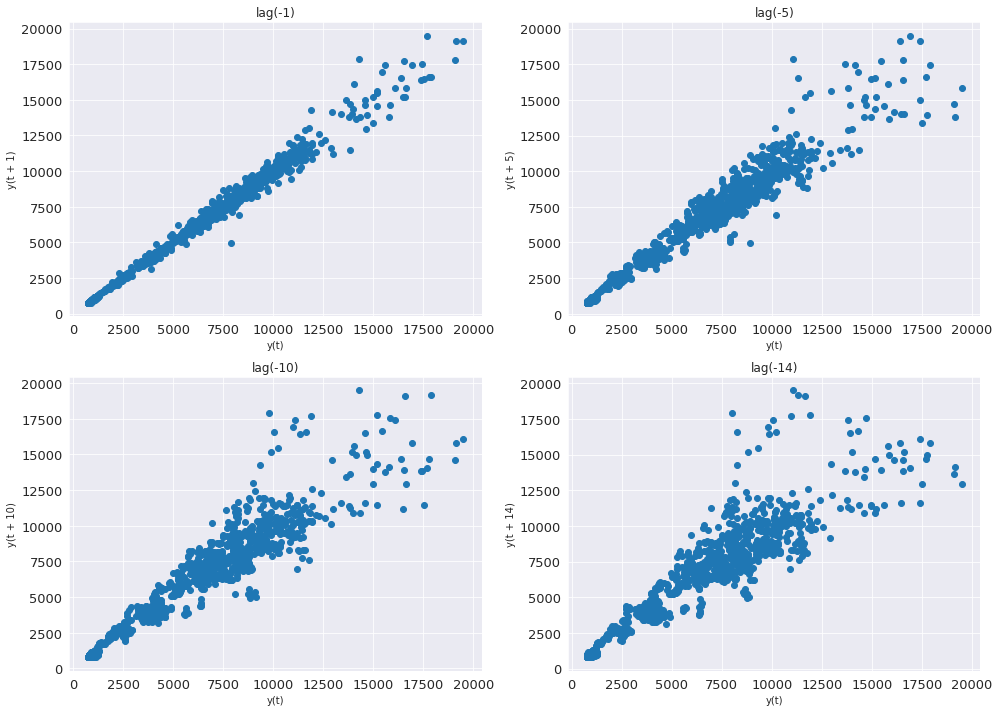

In [129]:
# Create the figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

# Create all the lag plots: -1. -5, -10 , -15
lag_plot(btc_trends[['Price']], 1,  ax=ax[0][0])
ax[0][0].set_title('lag(-1)')

lag_plot(btc_trends[['Price']], 5,  ax=ax[0][1])
ax[0][1].set_title('lag(-5)')

lag_plot(btc_trends[['Price']], 10,  ax=ax[1][0])
ax[1][0].set_title('lag(-10)')

lag_plot(btc_trends[['Price']], 14, ax=ax[1][1])
ax[1][1].set_title('lag(-14)')

fig.tight_layout()
plt.show()

In [130]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("Lag -1", "Lag -5", "Lag -10", "Lag -14"))
df1 = pd.concat([btc_trends[['Price']], btc_trends[['Price']].rename(columns={'Price':'Lag-1'}).shift(1)], axis=1).dropna()
df5 = pd.concat([btc_trends[['Price']], btc_trends[['Price']].rename(columns={'Price':'Lag-5'}).shift(5)], axis=1).dropna()
df10 = pd.concat([btc_trends[['Price']], btc_trends[['Price']].rename(columns={'Price':'Lag-10'}).shift(10)], axis=1).dropna()
df14 = pd.concat([btc_trends[['Price']], btc_trends[['Price']].rename(columns={'Price':'Lag-14'}).shift(14)], axis=1).dropna()

# Add traces
fig.add_trace(
    go.Scatter(x=df1['Price'], y=df1['Lag-1'], mode='markers', name='lag-1'),
    row=1, col=1)
fig.add_trace(
    go.Scatter(x=df5['Price'], y=df5['Lag-5'], mode='markers', name='lag-5'),
    row=1, col=2)
fig.add_trace(
    go.Scatter(x=df10['Price'], y=df10['Lag-10'], mode='markers', name='lag-10'),
    row=2, col=1)
fig.add_trace(
    go.Scatter(x=df14['Price'], y=df14['Lag-14'], mode='markers', name='lag-14'),
    row=2, col=2)

# Update xaxis properties
fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)
fig.update_xaxes(title_text="Price", row=2, col=1)
fig.update_xaxes(title_text="Price", row=2, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Lag -1 Price ", row=1, col=1)
fig.update_yaxes(title_text="Lag -5 Price ", row=1, col=2)
fig.update_yaxes(title_text="Lag -10 Price ", row=2, col=1)
fig.update_yaxes(title_text="Lag -14 Price ", row=2, col=2)


fig.update_layout(height=700, width=1000)
pio.write_html(fig, file='../figs/scatter_btc.html', auto_open=True)
fig.show()

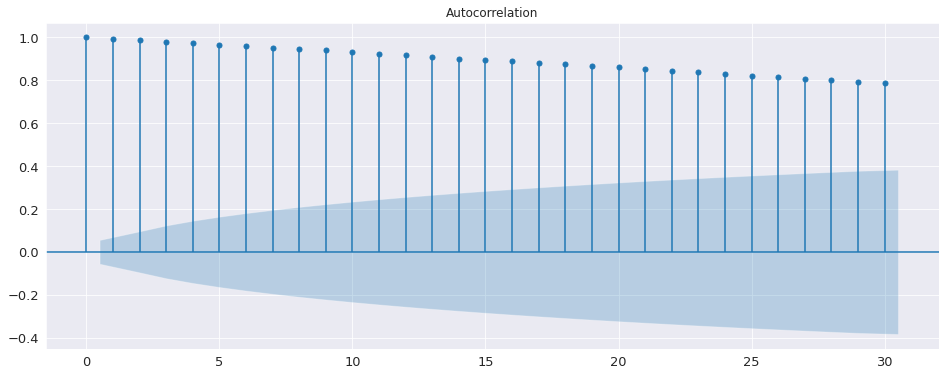

In [19]:
# plot the autocorrelation for 30 days
plot_acf(btc_trends['Price'], lags=30)
plt.show()

## Build models

Use the `AutoReg` model from `statsmodels` to build and fit auto regression models to our data
<hr>

## In-sample models
Predict data that are already seen. Feed the whole data to the models and predict the whole time series

### Base in-sample model

In [20]:
base_btc = AutoReg(btc_trends.Price.values, lags=[1, 2, 3, 4, 5]).fit()
print(base_btc.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1247
Model:                     AutoReg(5)   Log Likelihood               -9095.735
Method:               Conditional MLE   S.D. of innovations            366.691
Date:                Fri, 18 Dec 2020   AIC                             11.820
Time:                        17:57:09   BIC                             11.849
Sample:                             5   HQIC                            11.831
                                 1247                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     47.2761     21.745      2.174      0.030       4.656      89.896
y.L1           1.0181      0.028     35.883      0.000       0.962       1.074
y.L2          -0.0345      0.041     -0.850      0.3

In [21]:
trends_btc = AutoReg(btc_trends.Price.values, lags=[1, 2, 3, 4, 5], exog=btc_trends.Trends.values).fit()
print(trends_snp.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  368
Model:                   AutoReg-X(5)   Log Likelihood               -1876.904
Method:               Conditional MLE   S.D. of innovations             42.589
Date:                Fri, 18 Dec 2020   AIC                              7.547
Time:                        17:57:09   BIC                              7.633
Sample:                             5   HQIC                             7.581
                                  368                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     89.7623     32.674      2.747      0.006      25.722     153.802
y.L1           0.6664      0.052     12.833      0.000       0.565       0.768
y.L2           0.4760      0.062      7.711      0.0

In [22]:
trends_news_btc = AutoReg(btc_trends.Price.values, lags=model_lags, exog=(btc_trends.Trends * btc_trends.Sent_polarity).values).fit()
print(trends_news_btc.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1247
Model:                   AutoReg-X(5)   Log Likelihood               -9094.117
Method:               Conditional MLE   S.D. of innovations            366.214
Date:                Fri, 18 Dec 2020   AIC                             11.819
Time:                        17:57:10   BIC                             11.852
Sample:                             5   HQIC                            11.832
                                 1247                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     53.9952     22.035      2.450      0.014      10.807      97.183
y.L1           1.0206      0.028     35.975      0.000       0.965       1.076
y.L2          -0.0348      0.041     -0.859      0.3

Base in sample MAE: 20.234
Trends in sample MAE: 27.771
Trends with news, in sample MAE: 24.296


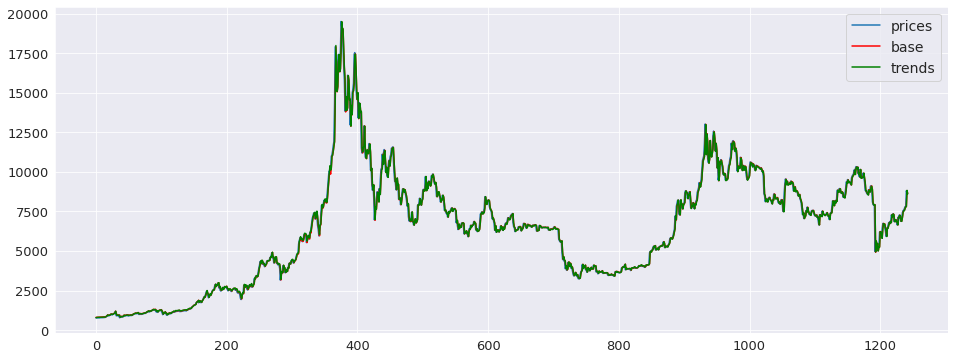

In [23]:
pred_base = base_btc.predict(start=5, end=len(btc_trends.Price.values))
pred_trends = trends_btc.predict(start=5, end=len(btc_trends.Price.values), exog_oos=btc_trends.Trends.values)
pred_trends_news = trends_news_btc.predict(start=len(model_lags), end=len(btc_trends.Price.values), exog_oos=(btc_trends.Trends * btc_trends.Sent_polarity).values)

# Compute MAE
mae_base = mean_absolute_error(btc_trends.iloc[4:,0], pred_base)
mae_trends = mean_absolute_error(btc_trends.iloc[4:,0], pred_trends)
mae_trends_news = mean_absolute_error(btc_trends.iloc[len(model_lags)-1:,0], pred_trends_news)
print('Base in sample MAE: %.3f' % mae_base)
print('Trends in sample MAE: %.3f' % mae_trends)
print('Trends with news, in sample MAE: %.3f' % mae_trends_news)

# Plor in sample predictions (this is not the figure to reproduce!)
plt.plot(btc_trends.iloc[5:, 0].values )
plt.plot(pred_base, 'red')
plt.plot(pred_trends, 'green')
plt.legend(['prices', 'base', 'trends'])


## Out of sample models


In [215]:
# Define model lags
model_lags = [1, 2, 3, 4, 5]

# Store the predictions
y_base = []
y_trends = [] 
y_trends_news = [] 
dates_pred = []

# Skip the first 12 obs 
window_size = 12
for last_window_idx in range(btc_trends.shape[0] - window_size):  # Leaves out the last idx that we dont want eitherway
    roll = last_window_idx + window_size

    # Slice the original data to the training window
    price_window = btc_trends[:roll]['Price']

    # Slice the trends to the training window
    trends_window = btc_trends[:roll]['Trends']

    # Slice the sentiment to the training window        
    polarized_trends = trends_window * btc_trends[:roll]['Sent_polarity']

    # Train 2 modesl on the window
    base_model = AutoReg(price_window.values, lags= model_lags).fit()
    trends_model = AutoReg(price_window.values, lags= model_lags, exog=trends_window.values).fit(use_t=True)
    trends_news_model = AutoReg(price_window.values, lags= model_lags, exog=polarized_trends.values).fit(use_t=True)
    
    # Predict using the params of the model (manually)
    y_base.append( 
        np.sum([price_window.iloc[-1 * lag] * base_model.params[idx+1] for idx, lag in enumerate(model_lags)]) + base_model.params[0])

    y_trends.append(
        np.sum([price_window.iloc[-1 * lag] * trends_model.params[idx+1] for idx, lag in enumerate(model_lags)])
             + trends_model.params[0]
             + btc_trends.iloc[roll]['Trends'] * trends_model.params[len(model_lags)+1]) # idx of exog is sizeof(lags) + 1

    y_trends_news.append(
        np.sum([price_window.iloc[-1 * lag] * trends_news_model.params[idx+1] for idx, lag in enumerate(model_lags)])
             + trends_news_model.params[0]
             + btc_trends.iloc[roll]['Trends'] * trends_news_model.params[len(model_lags)+1]) # idx of exog is sizeof(lags) + 1        
    
    # Keep the predicted days also
    dates_pred.append(btc_trends.index[roll])

# Create a dataframe or the preictions
base_preds = pd.DataFrame({'Price_base': y_base}, index=dates_pred)
trends_preds = pd.DataFrame({'Price_trends': y_trends}, index=dates_pred)
trends_news_preds = pd.DataFrame({'Price_trends_news': y_trends_news}, index=dates_pred)

# Also concat the predictions with the main df (for printing reasons mainly)
prices_with_preds = pd.concat([btc_trends.iloc[window_size:][['Price']], base_preds, trends_preds, trends_news_preds], axis=1)


In [216]:
from IPython.display import HTML

# Define turning point blocks
turning_points = {'All time: 2017-11-01 -2018-02-01': ('2017-11-01', '2018-02-01'),\
                  'Focus on increase: 2017-11-01 - 2017-12-16': ('2017-11-01', '2017-12-16'),
                  'Focus on decrease: 2018-01-15 - 2018-02-05': ('2018-01-15', '2018-02-05')}                  

# For each turning point find the baseline mae & trends mae
rows_of_table = list()

for period in turning_points.values():
    prices = btc_trends[period[0]:period[1]]['Price']
    base_prices = base_preds[period[0]:period[1]]['Price_base']
    trends_prices = trends_preds[period[0]:period[1]]['Price_trends']
    trends_news_prices = trends_news_preds[period[0]:period[1]]['Price_trends_news']

    mae_base = mean_absolute_error(prices, base_prices)    
    mae_trends = mean_absolute_error(prices, trends_prices)
    mae_trends_news = mean_absolute_error(prices, trends_news_prices)    

    rows_of_table.append([f'{period[0]}', f'{period[1]}', f'{mae_base:.5f}', f'{mae_trends:.5f}', f'{mae_trends_news:.5f}'] )    

# Add the overall mae also
prices = btc_trends[window_size:]['Price']
base_prices = base_preds['Price_base']
trends_prices = trends_preds['Price_trends']
trends_news_prices = trends_news_preds['Price_trends_news']
mae_base = mean_absolute_error(prices, base_prices)    
mae_trends = mean_absolute_error(prices, trends_prices)
mae_trends_news = mean_absolute_error(prices, trends_news_prices)
rows_of_table.insert(0, [f'Overall', '-', f'{mae_base:.5f}', f'{mae_trends:.5f}', f'{mae_trends_news:.5f}'])

table_df = pd.DataFrame(rows_of_table, columns=['Start', 'End', 'MAE base', 'MAE trends', 'MAE Trends news'])
HTML(table_df.to_html(index=False))  

Start,End,MAE base,MAE trends,MAE Trends news
Overall,-,208.04470,208.72817,208.56969
2017-11-01,2018-02-01,703.63743,707.24709,706.64730
2017-11-01,2017-12-16,509.54861,519.77977,515.74989
2018-01-15,2018-02-05,592.41766,591.45025,599.48685


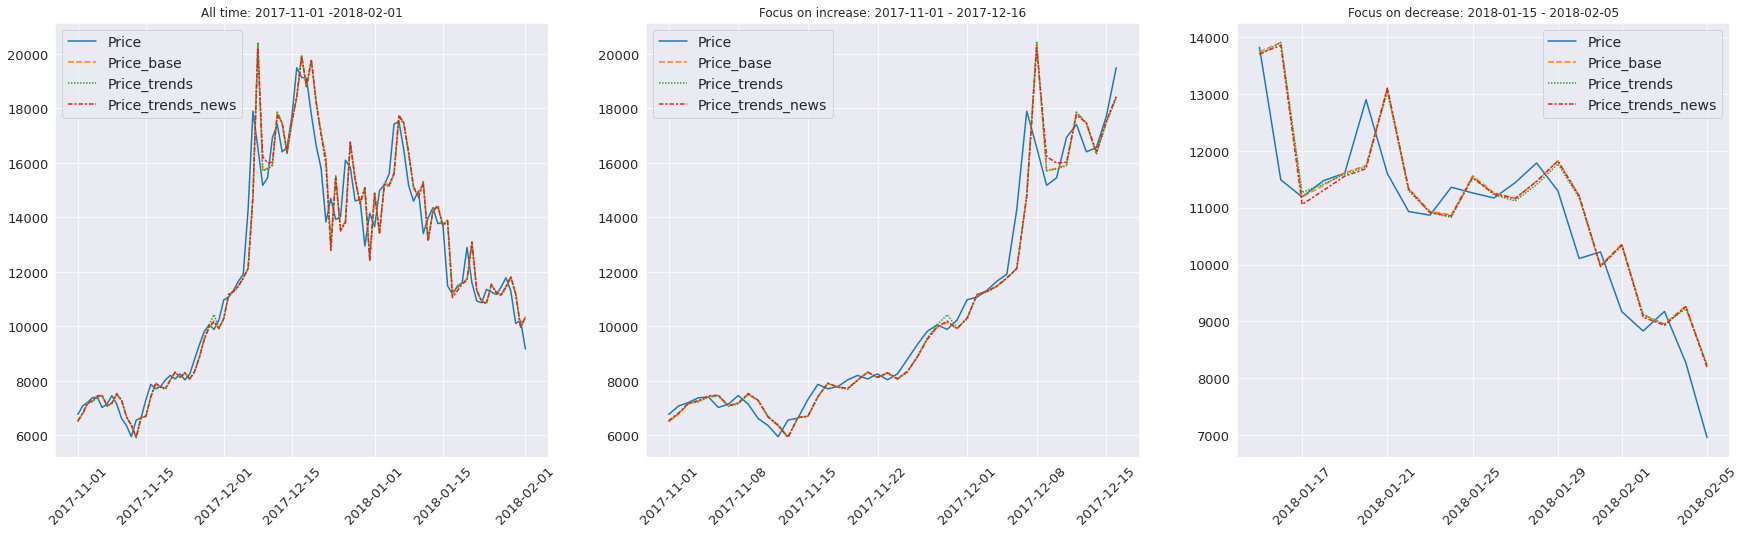

In [220]:
f,ax = plt.subplots(1,len(turning_points), figsize=(30,8))
for idx, period_with_names in enumerate(turning_points.items()):
    period = period_with_names[1]
    title = period_with_names[0]
    g = sns.lineplot(data=prices_with_preds[period[0]:period[1]], ax=ax[idx])
    g.set_title(title)
    for item in g.get_xticklabels():
        item.set_rotation(45)

In [222]:
# Create figure
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=list(prices_with_preds['2017-11-01':'2018-02-01'].index), y=list(prices_with_preds['2017-11-01':'2018-02-01'].Price), name="Bitcoin Prices"))
fig.add_trace(
    go.Scatter(x=list(prices_with_preds['2017-11-01':'2018-02-01'].index), y=list(prices_with_preds['2017-11-01':'2018-02-01'].Price_base), name="Baseline", line=dict(dash='dash')))
fig.add_trace(
    go.Scatter(x=list(prices_with_preds['2017-11-01':'2018-02-01'].index), y=list(prices_with_preds['2017-11-01':'2018-02-01'].Price_trends), name="Trends", line=dict(dash='dash')))
fig.add_trace(
    go.Scatter(x=list(prices_with_preds['2017-11-01':'2018-02-01'].index), y=list(prices_with_preds['2017-11-01':'2018-02-01'].Price_trends_news), name="Trends & News", line=dict(dash='dash', color='orange')))


fig.update_layout(title="Bitcoin predictions during 2017-2018", height=500, width=800)
fig.show()
pio.write_html(fig, file='../figs/lines_btc_rise.html', auto_open=True)

In [179]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(prices_with_preds.index), y=list(prices_with_preds.Price), name="Bitcoin Prices"))
fig.add_trace(
    go.Scatter(x=list(prices_with_preds.index), y=list(prices_with_preds.Price_base), name="Baseline", line=dict(dash='dash')))
fig.add_trace(
    go.Scatter(x=list(prices_with_preds.index), y=list(prices_with_preds.Price_trends), name="Trends", line=dict(dash='dash')))
fig.add_trace(
    go.Scatter(x=list(prices_with_preds.index), y=list(prices_with_preds.Price_trends), name="Trends & News", line=dict(dash='dash', color='orange')))

# Set title
fig.update_layout(
    title_text="Bitcoin Price predictions"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=1,label="1m",step="month",stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year",stepmode="todate"),
                dict(count=1,label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.update_layout(height=500, width=800)
fig.show()
pio.write_html(fig, file='../figs/btc_preds.html', auto_open=True)